In [1]:
#| output: false
import smile_extract
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from omegaconf import OmegaConf,DictConfig
from pathlib import Path
from src.munge import multivalue_xs, hierarchical_assign, get_index_level
from src.time_slice import reindex_trial_from_event
from src.timeseries import estimate_kinematic_derivative
%matplotlib inline

In [2]:
args = DictConfig({
    'trialframe_dir': Path('../data/trialframe'),
    'dataset':  'Dwight_2025-01-01',
    'composition_config': Path('../conf/trialframe.yaml'),
})

In [3]:
from src.io import generic_preproc
preproc = generic_preproc(args)
preproc

signal                                                                                                hand position  \
channel                                                                                                           x   
block                                trial_id time                   task state                                       
reward-type-medium-large-cst-rtt-dco 439      0 days 00:00:00.300000 CST  Hold Center (Ambiguous Cue)    127.438423   
                                              0 days 00:00:00.310000 CST  Hold Center (Ambiguous Cue)    126.950790   
                                              0 days 00:00:00.320000 CST  Hold Center (Ambiguous Cue)    126.484056   
                                              0 days 00:00:00.330000 CST  Hold Center (Ambiguous Cue)    126.012660   
                                              0 days 00:00:00.340000 CST  Hold Center (Ambiguous Cue)    125.538589   
...                                                                                                             ...   
reward-type-medium-cst-rtt-dco       422      0 days 00:00:02.500000 DCO  After Success Timeout          162.353957   
                                              0 days 00:00:02.510000 DCO  After Success Timeout          161.428133   
                                              0 days 00:00:02.520000 DCO  After Success Timeout          160.520005   
                                              0 days 00:00:02.530000 DCO  After Success Timeout          159.554396   
                                              0 days 00:00:02.540000 DCO  After Success Timeout          158.703567   

signal                                                                                                             \
channel                                                                                                         y   
block                                trial_id time                   task state                                     
reward-type-medium-large-cst-rtt-dco 439      0 days 00:00:00.300000 CST  Hold Center (Ambiguous Cue)  895.075994   
                                              0 days 00:00:00.310000 CST  Hold Center (Ambiguous Cue)  895.526018   
                                              0 days 00:00:00.320000 CST  Hold Center (Ambiguous Cue)  895.959750   
                                              0 days 00:00:00.330000 CST  Hold Center (Ambiguous Cue)  896.375967   
                                              0 days 00:00:00.340000 CST  Hold Center (Ambiguous Cue)  896.750948   
...                                                                                                           ...   
reward-type-medium-cst-rtt-dco       422      0 days 00:00:02.500000 DCO  After Success Timeout        889.124056   
                                              0 days 00:00:02.510000 DCO  After Success Timeout        888.690402   
                                              0 days 00:00:02.520000 DCO  After Success Timeout        888.293796   
                                              0 days 00:00:02.530000 DCO  After Success Timeout        887.903656   
                                              0 days 00:00:02.540000 DCO  After Success Timeout        887.571953   

signal                                                                                                            \
channel                                                                                                        z   
block                                trial_id time                   task state                                    
reward-type-medium-large-cst-rtt-dco 439      0 days 00:00:00.300000 CST  Hold Center (Ambiguous Cue)   8.947738   
                                              0 days 00:00:00.310000 CST  Hold Center (Ambiguous Cue)   8.614081   
                                              0 days 00:00:00.320000 CST  Hold Center (Ambiguous Cue)   8.311721  

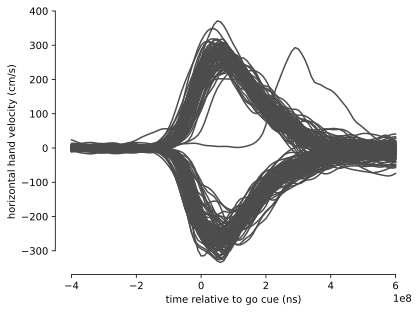

In [5]:
%matplotlib inline
from src.time_slice import slice_by_time, get_epoch_data
first_move_slice = slice(pd.to_timedelta('-0.4s'), pd.to_timedelta('0.6s'))
ax = sns.lineplot(
    data=(
        preproc
        .xs(level='task',key='DCO')
        .pipe(get_epoch_data,epochs={'Move': first_move_slice})
        ['hand velocity']
    ),
    x='time',
    y='x',
    units='trial_id',
    color='0.3',
    estimator=None,
    errorbar=None
)
sns.despine(ax=ax, trim=True)

ax.set_ylabel('horizontal hand velocity (cm/s)')
ax.set_xlabel('time relative to go cue (ns)')
plt.show()

/opt/homebrew/Caskroom/mambaforge/base/envs/cst-machinery/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


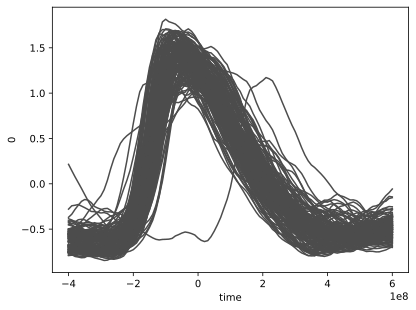

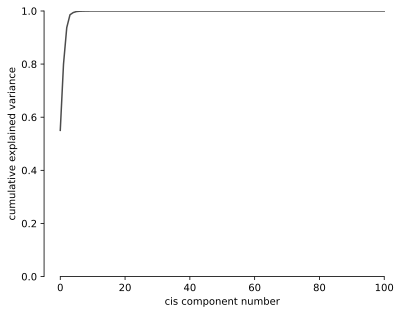

In [6]:
from sklearn.pipeline import Pipeline
from src.crystal_models import SoftnormScaler, BaselineShifter, CISFinder

trigger_ref_task = 'DCO'

preproc_pipeline = Pipeline([
    ('scaler', SoftnormScaler()),
    # ('baseline', BaselineShifter(ref_event='Hold Center (Ambiguous Cue)', ref_slice=slice('-0.3s','-0.05s'))),
])
cis_model = CISFinder(
    reference_task=trigger_ref_task,
    move_epoch={'Move': first_move_slice},
)
cis = (
    preproc
    ['motor cortex']
    .pipe(preproc_pipeline.fit_transform)
    # .dropna()
    .pipe(cis_model.fit_transform)
)

sns.lineplot(
    data=(
        cis
        .xs(level='task', key=trigger_ref_task)
        .pipe(get_epoch_data, epochs = {'Move': first_move_slice})
    ),
    x='time',
    y=0,
    color='0.3',
    units='trial_id',
    estimator=None,
)
ax.set_xlabel('time relative to go cue (s)')
ax.set_ylabel('first condition invariant dimension')
sns.despine(ax=ax,trim=True)

fig,ax=plt.subplots()
ax.plot(
    np.cumsum(cis_model.transformer.explained_variance_ratio_),
    color='0.3',
)
ax.set_ylim([0,1])
ax.set_ylabel('cumulative explained variance')
ax.set_xlabel('cis component number')
sns.despine(ax=ax, trim=True)

In [16]:
np.cumsum(cis_model.transformer.explained_variance_ratio_)

array([0.55042462, 0.79965744, 0.93729025, 0.98571982, 0.99405529,
       0.99785854, 0.99899507, 0.99946848, 0.9997268 , 0.99984392,
       0.99991404, 0.99994817, 0.99997188, 0.99998351, 0.99998812,
       0.99999172, 0.99999394, 0.9999954 , 0.9999965 , 0.99999745,
       0.999998  , 0.99999842, 0.99999877, 0.99999908, 0.99999929,
       0.99999943, 0.99999952, 0.9999996 , 0.99999966, 0.99999972,
       0.99999977, 0.9999998 , 0.99999984, 0.99999986, 0.99999989,
       0.9999999 , 0.99999991, 0.99999993, 0.99999994, 0.99999994,
       0.99999995, 0.99999996, 0.99999996, 0.99999996, 0.99999997,
       0.99999997, 0.99999997, 0.99999998, 0.99999998, 0.99999998,
       0.99999998, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

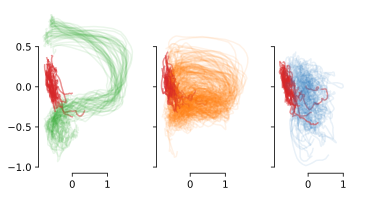

In [9]:
from src.time_slice import slice_by_time
from src.munge import get_index_level
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(
    n_splits=1,
    test_size=0.3,
)
_,sample_idx = next(gss.split(cis, groups=get_index_level(cis,'trial_id')))
cis_sampled = cis.iloc[sample_idx]

prego_slice = slice(pd.to_timedelta('-0.2s'), pd.to_timedelta('0s'))
postgo_slice = slice(pd.to_timedelta('0s'), pd.to_timedelta('3s'))

# trial_ids = [193,76]
trial_ids = [183,3]
# trial_ids = [76,354]
# trials_to_plot = multivalue_xs(preproc, level='trial_id', keys=trial_ids)
fig,axs = plt.subplots(1,3,figsize=(6,3),sharey=True,sharex=True)
for task,task_df in cis_sampled.groupby('task'):
    for _,trial in task_df.groupby('trial_id'):
        indices_to_drop = list(set(trial.index.names) - {'trial_id','time'})
        temp = (
            trial
            #.reset_index(level=indices_to_drop, drop=True)
        )
        prego = get_epoch_data(temp, epochs={'Target On': prego_slice})
        postgo = get_epoch_data(temp, epochs={'Go Cue': postgo_slice})
        if task == 'CST':
            axs[2].plot(prego[0],prego[1],color='tab:red',alpha=0.5)
            axs[2].plot(postgo[0],postgo[1],color='tab:blue',alpha=0.1)
        elif task == 'RTT':
            axs[1].plot(prego[0],prego[1],color='tab:red',alpha=0.5)
            axs[1].plot(postgo[0],postgo[1],color='tab:orange',alpha=0.1)
        elif task == 'DCO':
            axs[0].plot(prego[0],prego[1],color='tab:red',alpha=0.5)
            axs[0].plot(postgo[0],postgo[1],color='tab:green',alpha=0.1)

sns.despine(fig=fig,trim=True)

# sns.relplot(
#     data=cis_sampled,
#     x='relative time',
#     y=1,
#     hue='task',
#     row='task',
#     kind='line',
#     units='trial_id',
#     estimator=None,
#     errorbar=None,
#     aspect=2,
# )

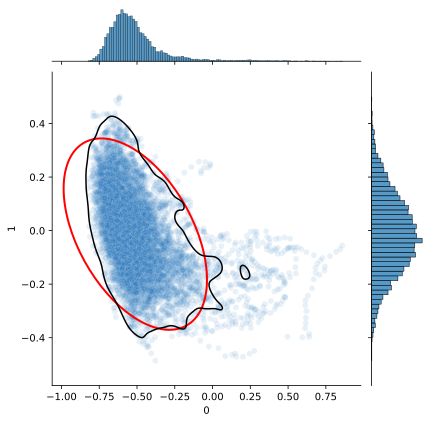

In [10]:
from matplotlib.patches import Ellipse

prego_cis = (
    cis
    #.xs(level='task',key='DCO')
    .pipe(get_epoch_data,epochs={'Target On': prego_slice})
)

# Assuming prego_cis is a DataFrame with at least two columns for the multidimensional data
data = prego_cis.values[:, :2]

# Calculate the mean of the data
mean = np.mean(data, axis=0)

# Calculate the covariance matrix
cov = np.cov(data, rowvar=False)

# Eigen decomposition
eigenvalues, eigenvectors = np.linalg.eigh(cov)

# Calculate the angle of the ellipse
angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

# Calculate the width and height of the ellipse
width, height = 2 * np.sqrt(eigenvalues * 5.991)  # 5.991 is the chi-square value for 95% confidence

# Plotting the ellipse
g = sns.jointplot(
    data=prego_cis,
    x=0,
    y=1,
    alpha=0.1,
)
g.plot_joint(sns.kdeplot, color='k', levels=[0.05])
ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor='r', fc='None', lw=2)
g.ax_joint.add_patch(ellipse)


In [11]:
from scipy.spatial.distance import mahalanobis,cdist

num_cis_dims = 4
prego_cis = (
    cis
    #.xs(level='task',key=trigger_ref_task)
    .pipe(get_epoch_data,epochs={'Target On': prego_slice})
)

def prego_mahal_distance(points: pd.DataFrame,num_dims=num_cis_dims) -> pd.DataFrame:
    assert num_dims <= prego_cis.shape[1], 'Number of dimensions exceeds number of dimensions in prego_cis'

    prego_mean = prego_cis.mean().values[np.newaxis,:num_dims]
    prego_cov = prego_cis.cov().values[:num_dims,:num_dims]
    
    return pd.DataFrame(
        cdist(points.loc[:,:(num_dims-1)],prego_mean,metric='mahalanobis',VI=np.linalg.pinv(prego_cov)),
        index=points.index,
    )

/opt/homebrew/Caskroom/mambaforge/base/envs/cst-machinery/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


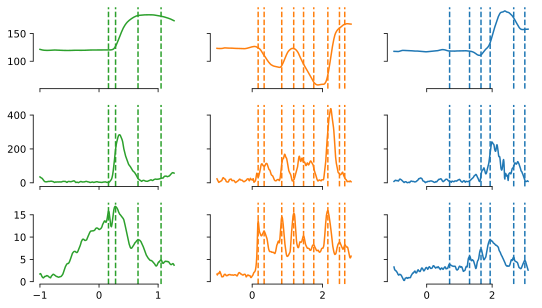

In [14]:
from scipy.signal import find_peaks
from src.munge import hierarchical_assign,multivalue_xs

trial_ids = (
    preproc
    .groupby('trial_id')
    .nth(0)
    .pipe(get_index_level, level='trial_id')
    .groupby('task')
    .sample(n=1)
    .values
)
cis_sampled= (
    preproc
    .pipe(get_epoch_data, epochs={'Go Cue': slice(pd.to_timedelta('-1.0s'), None)})
    .pipe(hierarchical_assign,{
        'cis': lambda df: (
            df['motor cortex']
            .pipe(preproc_pipeline.transform)
            .pipe(cis_model.transform)
        )
    })
    .assign(**{
        'cis mahalanobis distance': lambda df: prego_mahal_distance(df['cis']),
    })
    .assign(**{
        'hand_speed': lambda df: np.linalg.norm(df['hand velocity'],axis=1),
    })
    .loc[:,(['hand position','hand_speed','cis mahalanobis distance'],['x',''])]
    .droplevel('channel',axis=1)
    .assign(**{
        'dhand_speed': lambda x: x['hand_speed'].diff(),
        'dmahal': lambda df: df['cis mahalanobis distance'].groupby('trial_id').transform(lambda x: x.diff()),
    })
    .pipe(multivalue_xs, level='trial_id', keys=trial_ids)
)

fig,axs = plt.subplots(3,3,figsize=(9,5),sharex='col', sharey='row')
# for i,trial in trials_to_plot.reset_index().iterrows():
#     src.plot.plot_hand_trace(trial,ax=axs[0,i])
#     #axs[0,i].plot(reaction_time.loc[trial['trial_id']].total_seconds(),0,'ro')

for _,trial in cis_sampled.groupby('trial_id'):
    if trial.reset_index(level='task')['task'].values[0] == 'CST':
        col=2
        color='tab:blue'
    elif trial.reset_index(level='task')['task'].values[0] == 'RTT':
        col=1
        color='tab:orange'
    elif trial.reset_index(level='task')['task'].values[0] == 'DCO':
        col=0
        color='tab:green'

    axs[0,col].plot(get_index_level(trial,level='time')/np.timedelta64(1,'s'),trial['hand position'],color=color)
    axs[1,col].plot(get_index_level(trial,level='time')/np.timedelta64(1,'s'),trial['hand_speed'],color=color)
    axs[2,col].plot(get_index_level(trial,level='time')/np.timedelta64(1,'s'),trial['cis mahalanobis distance'],color=color)

    peaks, props = find_peaks(trial['cis mahalanobis distance'],prominence=1)
    # peaks, props = find_peaks(trial['dmahal'],prominence=1.25)
    for peak in peaks:
        for row in range(3):
            axs[row,col].axvline(get_index_level(trial,level='time').values[peak]/np.timedelta64(1,'s'),color=color,linestyle='--')

sns.despine(fig=fig,trim=True)

In [10]:
def find_peak_index(s: pd.Series,timecol: str='relative time',**kwargs):
    peak_idx,_ = find_peaks(s,**kwargs)
    return (
        s
        .reset_index(level=timecol)
        [timecol]
        .iloc[peak_idx]
    )

cis_peaks= (
    tf
    .pipe(src.munge.reindex_from_event_times,events.xs(key='ctHold',level='event'),timecol='trial time')
    ['lfads_rates']
    .pipe(
        lambda df: pd.DataFrame(
            dpca.transform(df.values.T,marginalization='t').T,
            index=df.index
        ),
    )
    .pipe(prego_mahal_distance)
    .squeeze()
    .rename('cis mahalanobis distance')
    .pipe(find_peak_index,prominence=1)
    .rename('cis peak times')
    .loc[lambda x: x > pd.Timedelta(0)]
    .to_frame()
    .assign(**{
        'peak number': lambda x: x.groupby('trial_id').cumcount(),
    })
    .set_index('peak number',append=True)
    .squeeze()
)
print(cis_peaks.loc[76])
print(target_times.loc[76])

NameError: name 'src' is not defined

In [ ]:
temp = (
    cis_peaks
    .groupby('peak number')
    .apply(lambda x: src.munge.reindex_from_event_times(
        tf,
        x.reset_index(level='peak number',drop=True),
        timecol='trial time'
    ))
    .loc[(slice(None),slice(None),slice('-0.5s','0.5s')),:]
)

ax = sns.lineplot(
    data=temp.reset_index().assign(**{'snip id': lambda x: x['trial_id'].astype(str) + '_' + x['peak number'].astype(str)}),
    x='relative time',
    y=('hand_speed',0),
    hue='task',
    # units='snip id',
    # estimator=None,
    # errorbar=None,
    # lw=0.5,
    errorbar='ci',
)
ax.set_ylabel('horizontal hand speed (cm/s)')
ax.set_xlabel('time relative to peak CIS (ns)')
sns.despine(ax=ax,trim=True)

In [ ]:
temp = (
    (cis_peaks + pd.to_timedelta(np.random.normal(0,0.5,cis_peaks.shape),unit='s').round('10ms'))
    .groupby('peak number')
    .apply(lambda x: src.munge.reindex_from_event_times(
        tf,
        x.reset_index(level='peak number',drop=True),
        timecol='trial time'
    ))
    .loc[(slice(None),slice(None),slice('-0.5s','0.5s')),:]
)

ax = sns.lineplot(
    data=temp,
    x='relative time',
    y=('hand_speed',0),
    hue='task',
    # units='snip id',
    # estimator=None,
    # errorbar=None,
    # lw=0.5,
    errorbar='ci',
)
ax.set_ylabel('horizontal hand speed (cm/s)')
ax.set_xlabel('time relative to jittered peak CIS (ns)')
sns.despine(ax=ax,trim=True)

In [ ]:
(
    cis_peaks
    + pd.TimedeltaIndex(np.random.normal(0,0.5,cis_peaks.shape),unit='s').round('10ms')
)

In [ ]:
trial_ids = [193,76]

trials_to_plot = td.set_index('trial_id').loc[trial_ids]
temp = (
    tf
    .pipe(src.munge.reindex_from_event_times,events.xs(key='goCue',level='event'),timecol='trial time')
    .loc[(trial_ids,slice('0s','4s')),:]
)

# fig, axs = plt.subplots(1,2,figsize=(8,4),sharex=True,sharey=True)
# for i,(_,trial) in enumerate(temp.groupby('trial_id')):
#     axs[i].plot(trial[('rel_hand_pos',0)],trial[('hand_vel',0)])

trials_to_plot['rt_locations']
target_times.loc[trial_ids]

def get_current_target_location(trial_id: int, trial_time: pd.Timedelta) -> float:
    trial_targets = target_times.loc[trial_id]

    if pd.isna(trial_targets.loc[0,'location']): # there's only one target, i.e. it's a CST trial
        return np.nan

    if trial_time < trial_targets['target onset'].values[0]:
        return 0

    for target_num,target_info in trial_targets.iterrows():
        if trial_time >= target_info['target onset'] and trial_time < target_info['target acquisition']:
            return target_info['location']

    return np.nan

def get_current_target_number(trial_id: int, trial_time: pd.Timedelta) -> int:
    trial_targets = target_times.loc[trial_id]

    if pd.isna(trial_targets.loc[0,'location']): # there's only one target, i.e. it's a CST trial
        return 0

    if trial_time < trial_targets['target onset'].values[0]:
        return 0

    for target_num,target_info in trial_targets.iterrows():
        if trial_time >= target_info['target onset'] and trial_time <= target_info['target acquisition']:
            return int(target_num)

    return 8

temp = (
    tf
    .loc[trial_ids]
    .assign(**{
        'target location': lambda df: (
            df
            .apply(lambda x: get_current_target_location(x.name[0],x.name[2]),axis=1)
        ),
        'target number': lambda df: (
            df
            .apply(lambda x: get_current_target_number(x.name[0],x.name[2]),axis=1)
        ),
    })
)
# sns.scatterplot(
#     data=temp.loc[76],
#     x=('target location',''),
#     y=('rel_hand_pos',0),
# )

sns.relplot(
    data=(
        temp
        .filter(items=[('rel_hand_pos',0),('hand_vel',0),('target location',''),('target number','')])
        .droplevel(1,axis=1)
    ),
    x='rel_hand_pos',
    y='hand_vel',
    col='task',
    hue='target number',
    kind='scatter',
    palette='tab10',
)
